In [2]:
import scvelo as scv
import scanpy as sc

In [2]:
# scv.logging.print_version()

Running scvelo 0.3.1 (python 3.9.18) on 2024-04-14 08:49.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
scv.set_figure_params()

# Merging loom file to get the layers

In [5]:
ldata = scv.read('./output/sample_alignments_DMIWJ.loom')

In [6]:
cdata = sc.read_10x_h5('./output/sample_filtered_feature_bc_matrix.h5', genome=None, gex_only=True, backup_url=None)

In [7]:
cdata

AnnData object with n_obs × n_vars = 6549 × 18082
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
adata = scv.utils.merge(cdata, ldata)

In [9]:
adata

AnnData object with n_obs × n_vars = 6549 × 18082
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [10]:
adata.layers['spliced']

<6549x18082 sparse matrix of type '<class 'numpy.uint32'>'
	with 227251 stored elements in Compressed Sparse Row format>

In [11]:
adata.layers['unspliced']

<6549x18082 sparse matrix of type '<class 'numpy.uint32'>'
	with 847326 stored elements in Compressed Sparse Row format>

# scRNA-seq Preprocessing

In [12]:
# Perform QC on cells and features
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [13]:
adata

AnnData object with n_obs × n_vars = 6548 × 13445
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

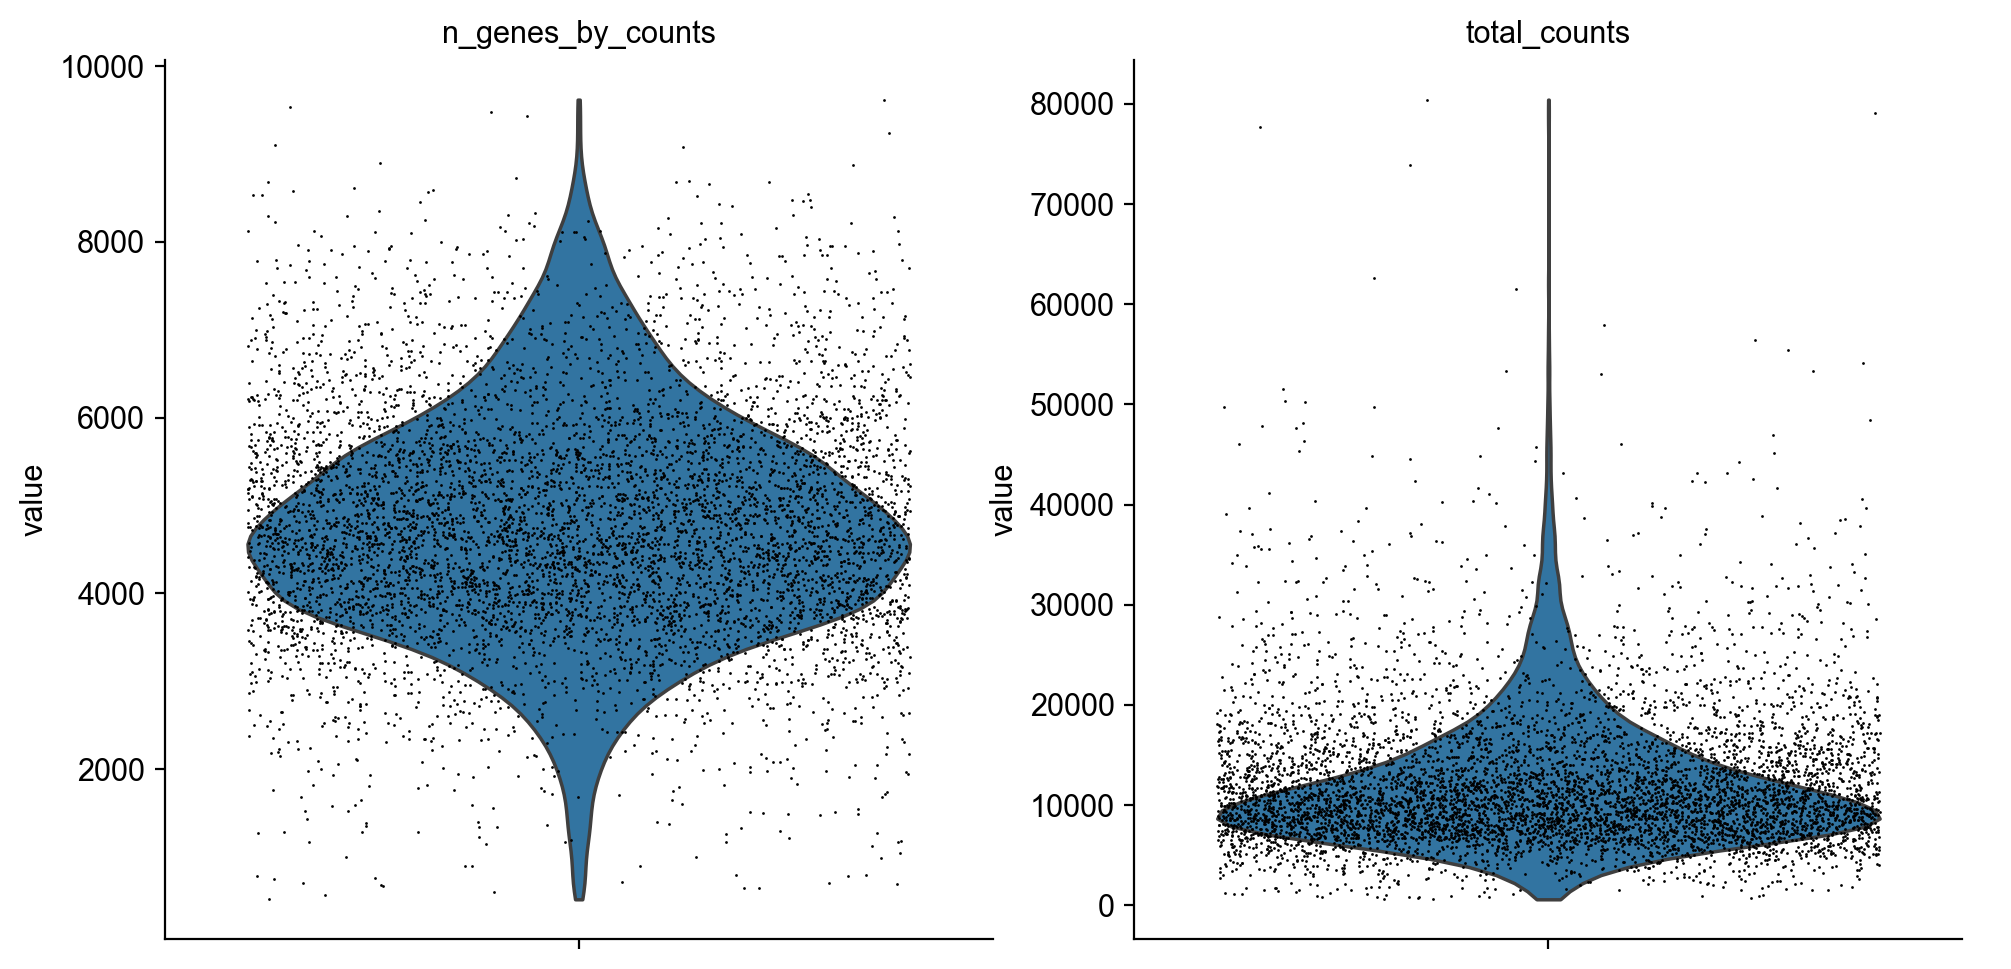

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [14]:
# Normalize the data and log-transform counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [16]:
adata.var_names

Index(['NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN',
       'RNF223', 'C1orf159', 'TTLL10',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=13445)

In [15]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
highly_variable_genes = adata.var_names[adata.var['highly_variable']]

In [16]:
highly_variable_genes

Index(['RNF223', 'TTLL10', 'TNFRSF18', 'MMP23B', 'HES5', 'TNFRSF14', 'KCNAB2',
       'GPR153', 'KLHL21', 'TNFRSF9',
       ...
       'GABRA3', 'GABRQ', 'ZNF185', 'PNCK', 'RENBP', 'TKTL1', 'DKC1', 'MT-ND1',
       'MT-CO2', 'MT-ND4L'],
      dtype='object', length=2000)

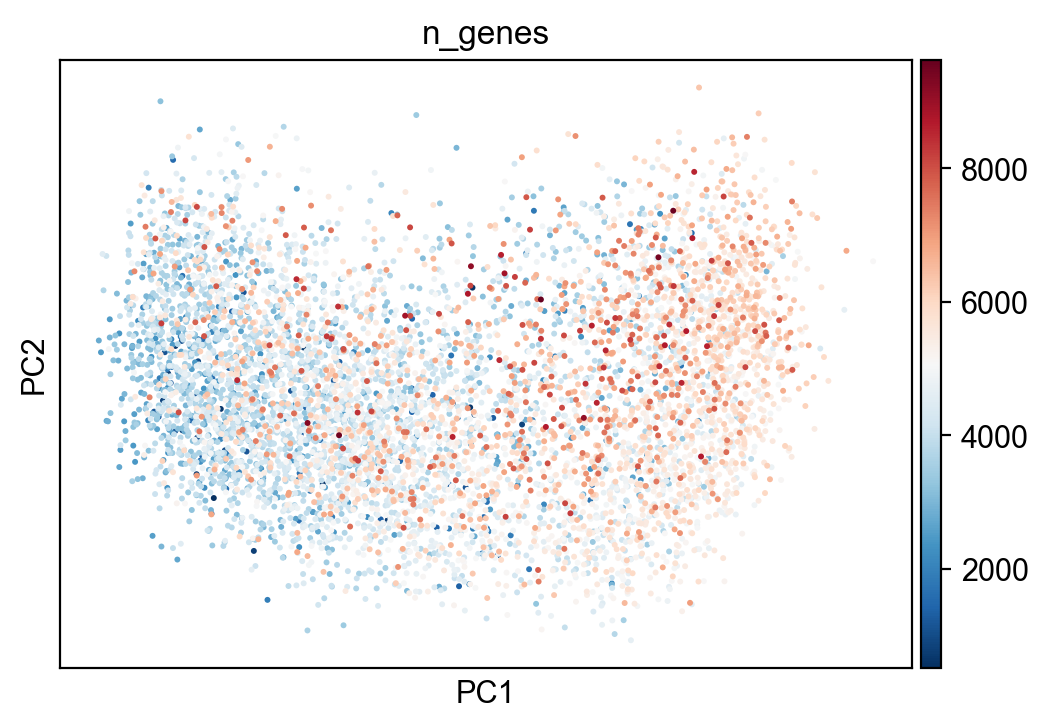

In [17]:
# Perform PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

# Visualize PCA
sc.pl.pca(adata,color='n_genes')

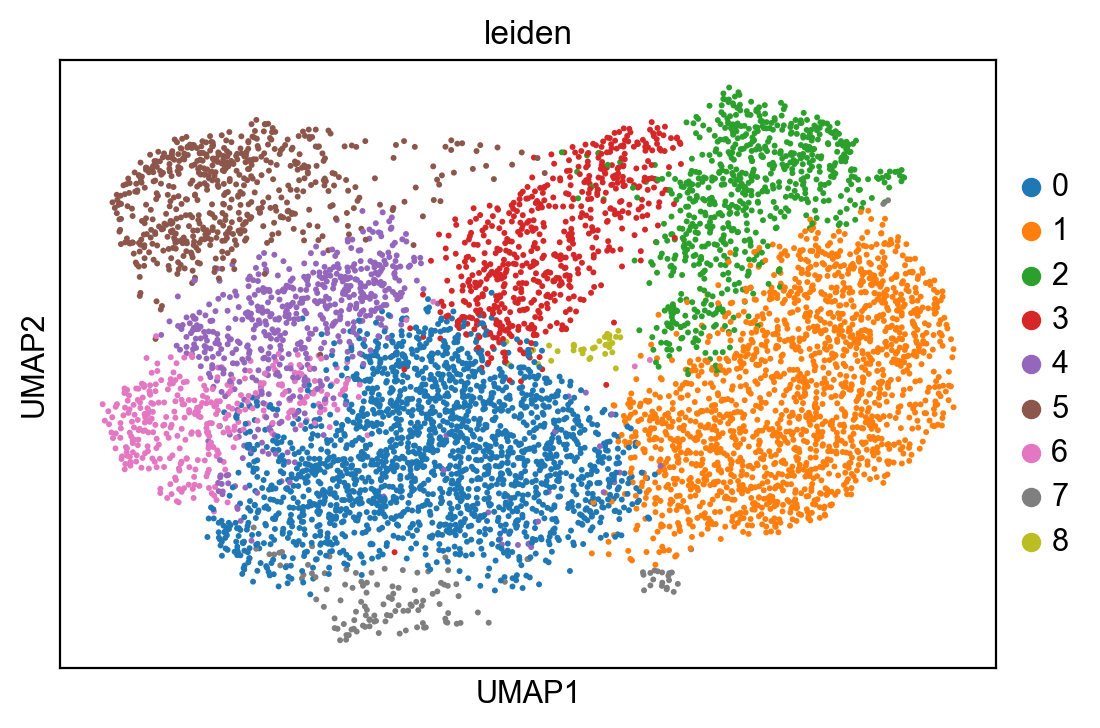

In [28]:
# Perform clustering (adjust resolution as needed)
sc.pp.neighbors(adata, n_pcs=40, n_neighbors=15)
sc.tl.leiden(adata, resolution=0.5)

# Compute UMAP coordinates
sc.tl.umap(adata)

# Visualize clusters
sc.pl.umap(adata, color='leiden', save='umap_plot.png')

In [21]:
adata

AnnData object with n_obs × n_vars = 6548 × 13445
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# scVelo Starts here

In [22]:
scv.pp.filter_and_normalize(adata)

Normalized count data: spliced, unspliced.
Logarithmized X.


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [19]:
scv.pp.moments(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [20]:
scv.tl.velocity(adata)

computing velocities
The correlation threshold has been reduced to 0.0.
Please be cautious when interpreting results.
    finished (0:00:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [21]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site

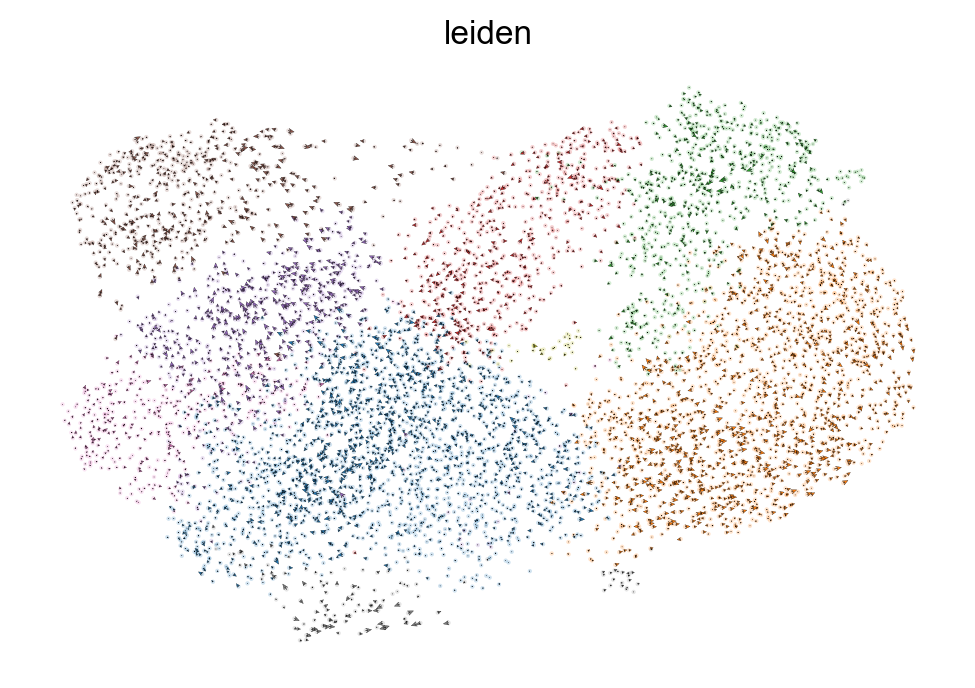

In [22]:
scv.pl.velocity_embedding(adata, basis='umap', color='leiden')

/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site

saving figure to file ./figures/scvelo_velo_plot.png


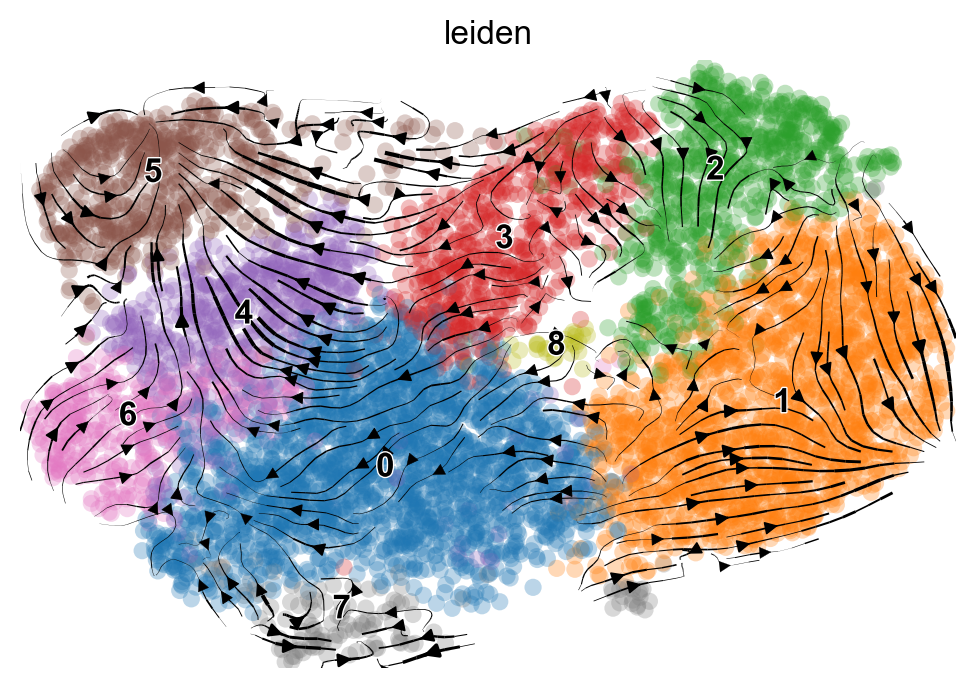

In [29]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden', save='velo_plot.png')

In [29]:
adata.var_names

Index(['NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN',
       'RNF223', 'C1orf159', 'TTLL10',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=13445)

saving figure to file ./figures/scvelo_phase_portrai1.png


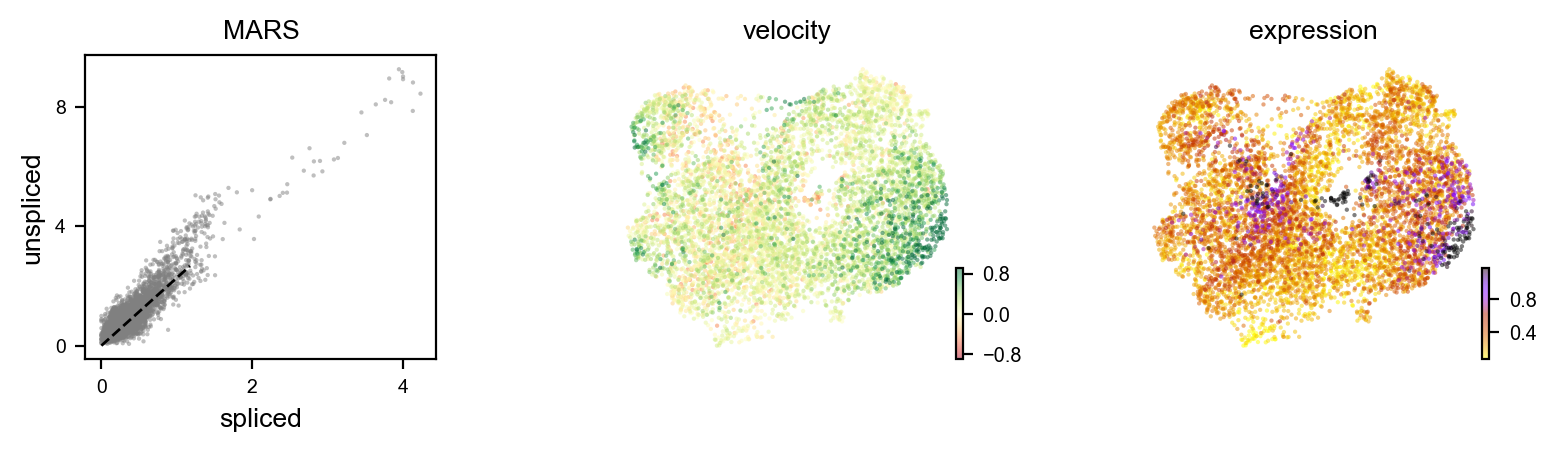

In [30]:
# Phase portrait
scv.pl.velocity(adata, var_names=['MARS'], save='phase_portrai1.png')


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site

saving figure to file ./figures/scvelo_phase_portrait2.png


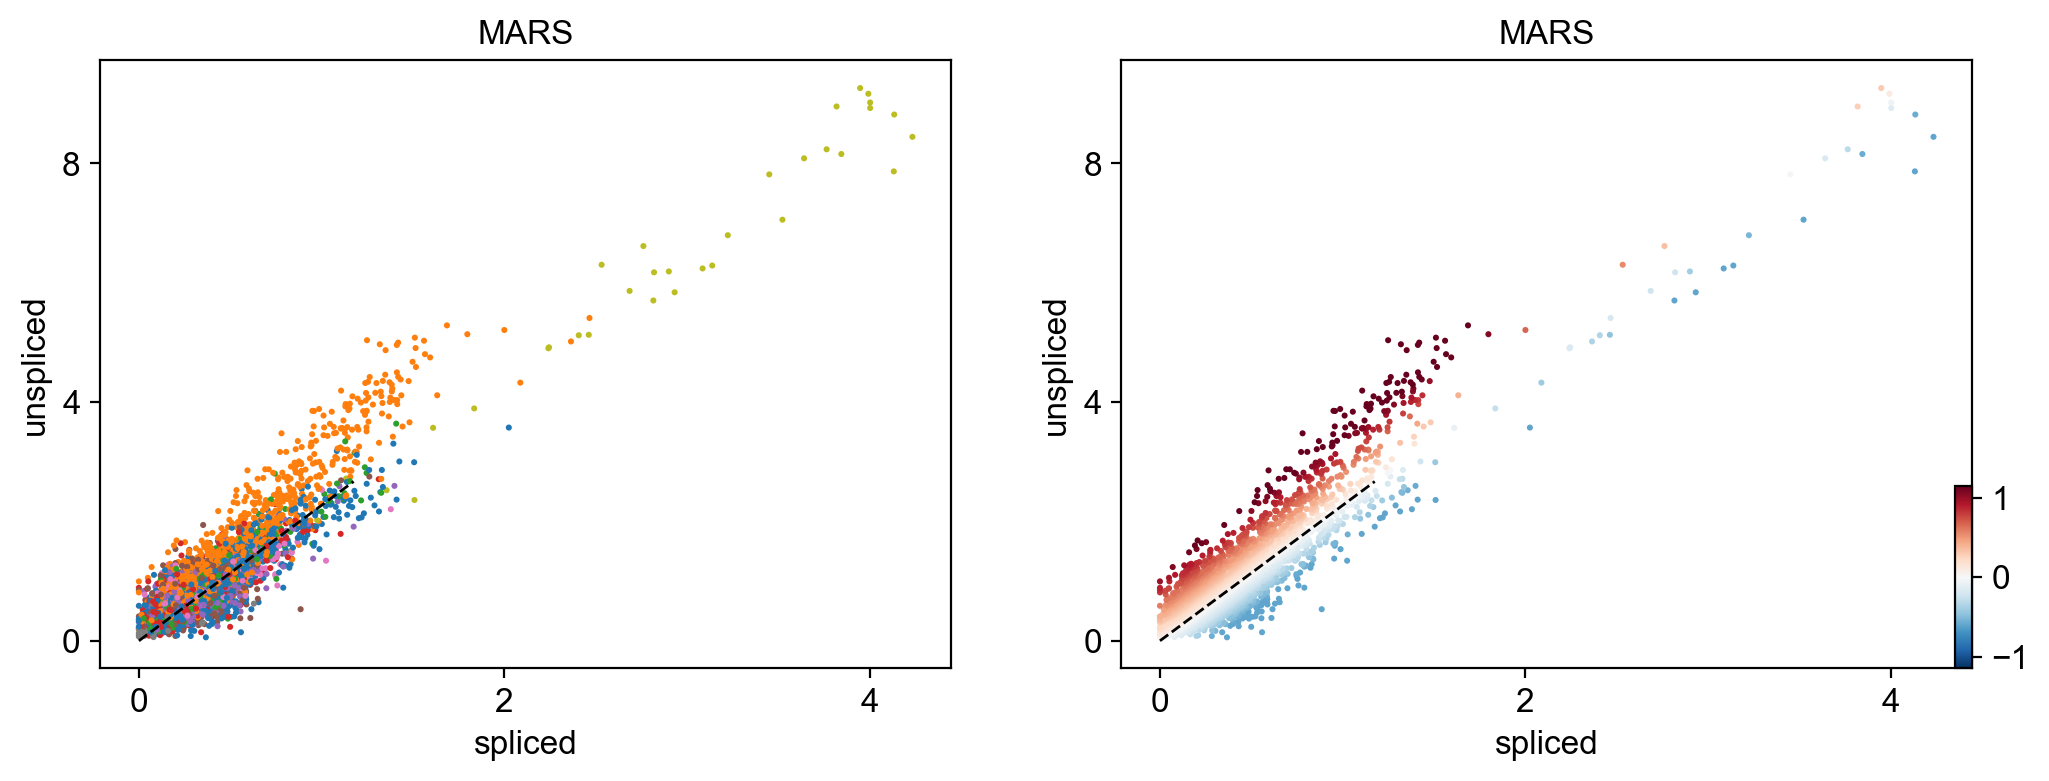

In [31]:
scv.pl.scatter(adata, 'MARS', color=['leiden', 'velocity'], save='phase_portrait2.png')

In [45]:
scv.tl.rank_velocity_genes(adata, groupby = 'leiden', min_corr=0.3)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [34]:
import pandas as pd

In [46]:
df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

0     1     2     3     4     5     6     7     8
0  MARS  MARS  MARS  MARS  MARS  MARS  MARS  MARS  MARS

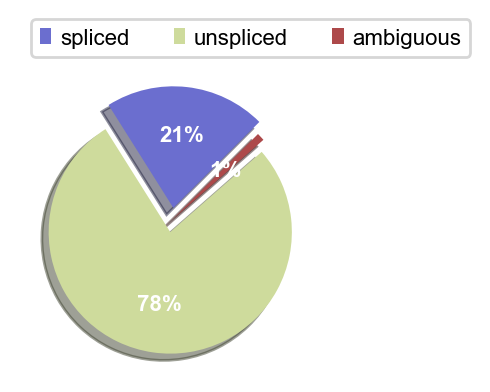

In [ ]:
scv.pl.proportions(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


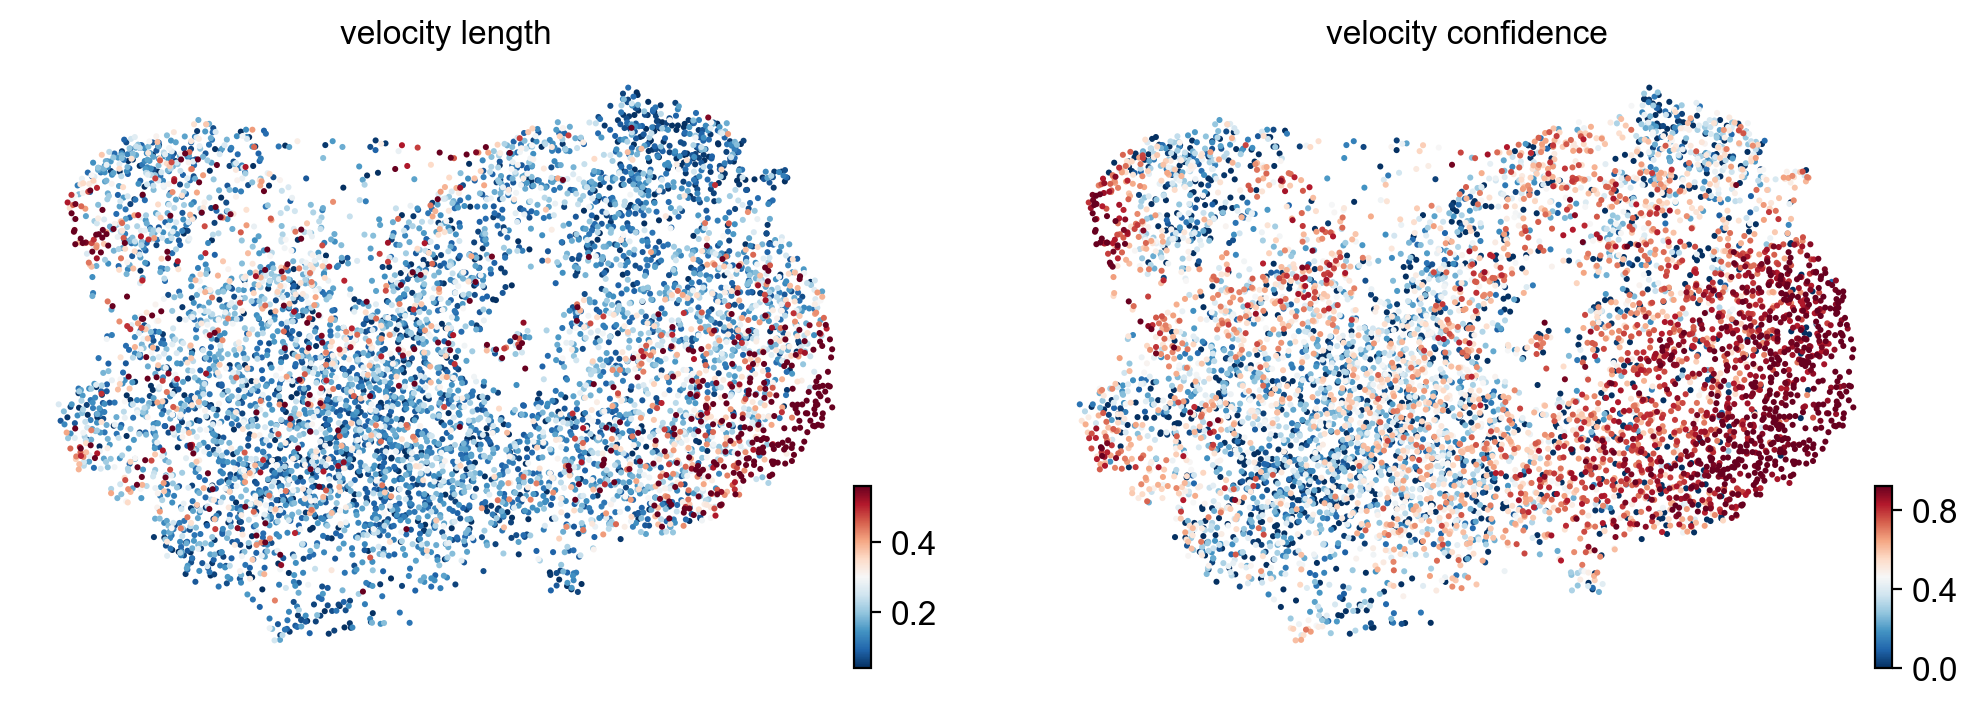

In [ ]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c = keys, perc = [5,95])

In [ ]:
adata.obs

sample_batch  initial_size_unspliced  initial_size_spliced  \
AAACAAGCAAAC    CGTAACTTTAGG-1                     721                   187   
AAACAAGCAAAC-1  GGGAACTTTAGG-1                     341                   100   
AAACAAGCAGGT    GACTACTTTAGG-1                     471                   111   
AAACAAGCAGGT-1  TTCTACTTTAGG-1                     942                   268   
AAACAAGCATCA    CTCGACTTTAGG-1                     381                   115   
...                        ...                     ...                   ...   
TTTGGCGGTTCC    TTTGACTTTAGG-1                     292                    78   
TTTGGCGGTTGA    GTCTACTTTAGG-1                    1004                   244   
TTTGTGAGTGAC    CTATACTTTAGG-1                     597                   194   
TTTGTGAGTGAG    AAGGACTTTAGG-1                     384                    96   
TTTGTGAGTGTT    CCAGACTTTAGG-1                    1179                   273   

                initial_size  n_genes  n_genes_by_counts  total_counts leiden  \
AAACAAGCAAAC           187.0     4668               4668       10668.0      1   
AAACAAGCAAAC-1         100.0     3222               3222        5545.0      4   
AAACAAGCAGGT           111.0     3953               3953        7675.0      0   
AAACAAGCAGGT-1         268.0     5714               5714       15865.0      2   
AAACAAGCATCA           115.0     3509               3509        6529.0      0   
...                      ...      ...                ...           ...    ...   
TTTGGCGGTTCC            78.0     2855               2853        4528.0      4   
TTTGGCGGTTGA           244.0     5726               5725       15786.0      0   
TTTGTGAGTGAC           194.0     4764               4764       10127.0      1   
TTTGTGAGTGAG            96.0     3393               3393        6397.0      4   
TTTGTGAGTGTT           273.0     6539               6539       18818.0      0   

                   n_counts  velocity_self_transition  velocity_length  \
AAACAAGCAAAC    4596.490234                  0.000489             0.07   
AAACAAGCAAAC-1  4098.157715                  0.000000             0.12   
AAACAAGCAGGT    4390.554688                  0.000010             0.21   
AAACAAGCAGGT-1  4896.278809                  0.000080             0.01   
AAACAAGCATCA    4198.878418                  0.000003             0.33   
...                     ...                       ...              ...   
TTTGGCGGTTCC    3954.343994                  0.000003             0.19   
TTTGGCGGTTGA    4906.066895                  0.000035             0.10   
TTTGTGAGTGAC    4749.736328                  0.000403             0.64   
TTTGTGAGTGAG    4090.840332                  0.000016             0.30   
TTTGTGAGTGTT    5158.997070                  0.000034             0.04   

                velocity_confidence  velocity_confidence_transition  
AAACAAGCAAAC               0.000000                        0.783043  
AAACAAGCAAAC-1             0.410796                        0.999993  
AAACAAGCAGGT               0.474633                        0.999787  
AAACAAGCAGGT-1             0.211600                        0.963526  
AAACAAGCATCA               0.481775                        0.897171  
...                             ...                             ...  
TTTGGCGGTTCC               0.208199                        0.960783  
TTTGGCGGTTGA               0.412293                        0.978261  
TTTGTGAGTGAC               0.983943                        0.982002  
TTTGTGAGTGAG               0.574001                        0.985958  
TTTGTGAGTGTT               0.576461                        0.993334  

[6548 rows x 13 columns]

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


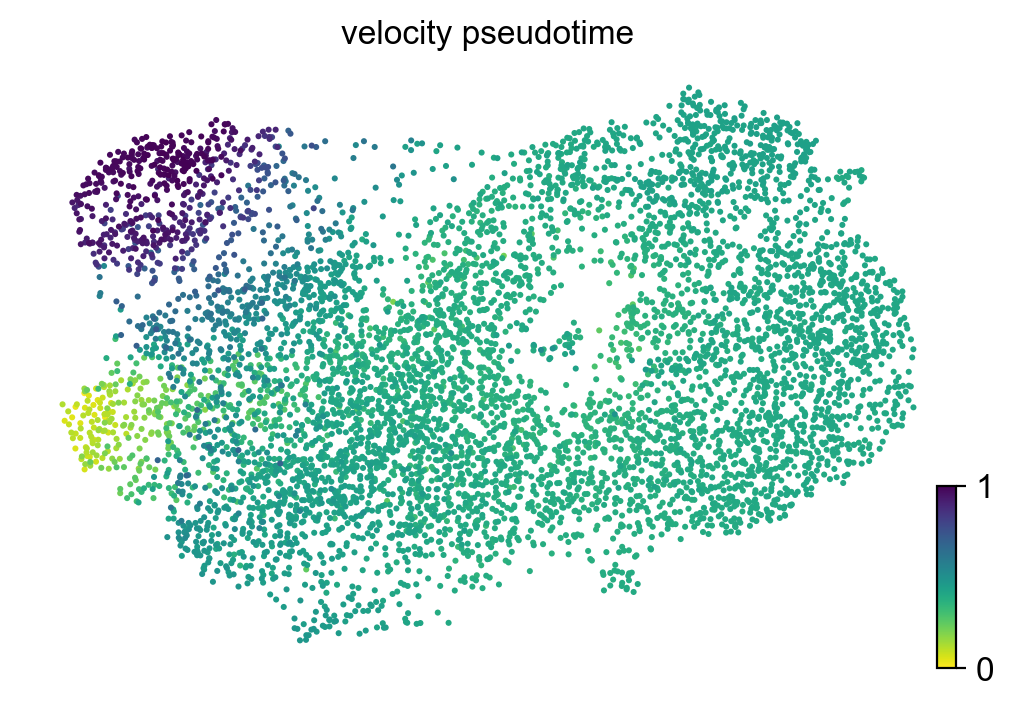

In [ ]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color = 'velocity_pseudotime')

recovering dynamics (using 8/8 cores)
    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: MARS
computing velocities
The correlation threshold has been reduced to 0.0.
Please be cautious when interpreting results.
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


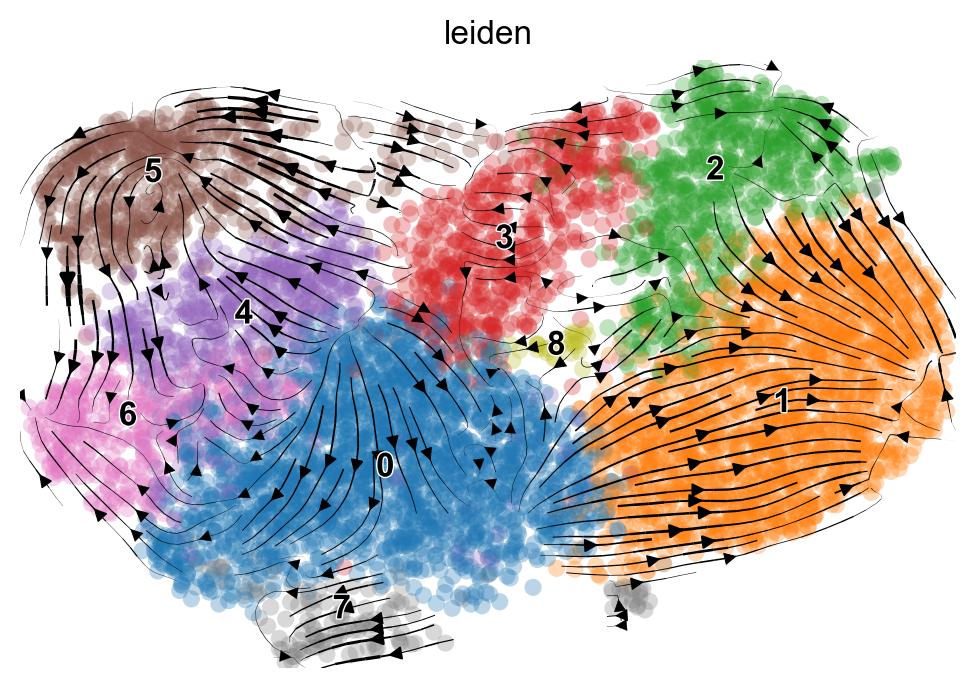

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs = 20)
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden')

computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


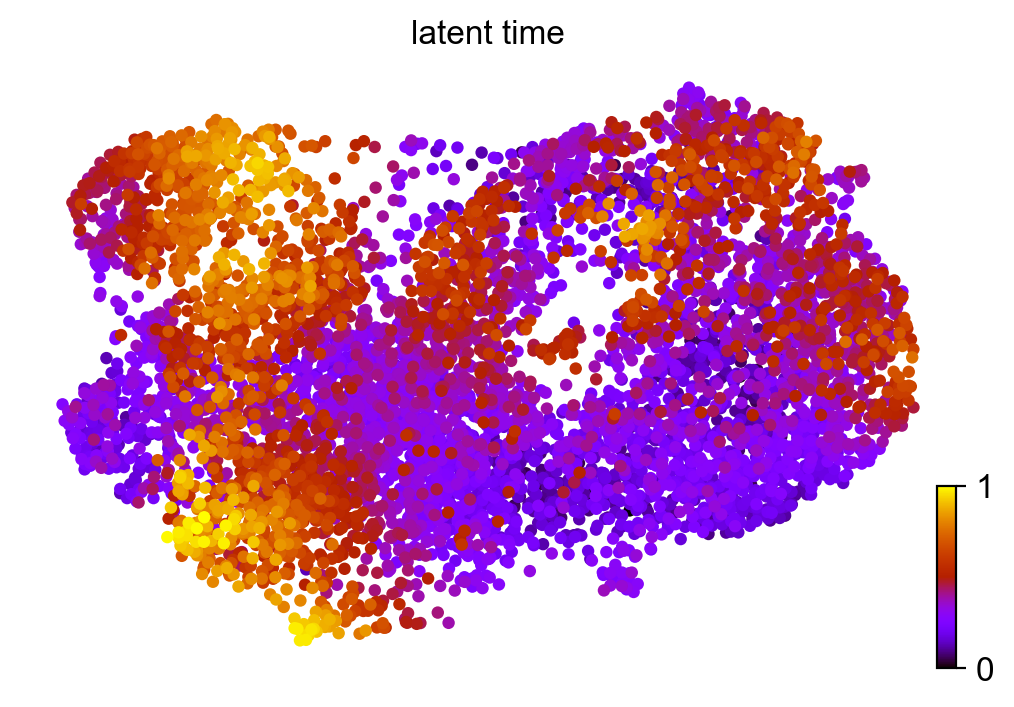

In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color = 'latent_time', color_map = 'gnuplot', size = 80)